
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [80]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [81]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [82]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


### KNN

In [83]:
# Converting y into categorical
ha['cp'] = ha['cp'].astype('category')
ha['sex'] = ha['sex'].astype('category')
ha['restecg'] = ha['restecg'].astype('category')
ha['output'] = ha['output'].astype('category')

#creating the target and the predictor variables
X= ha.drop(['cp'], axis=1)
y = ha['cp']

In [84]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [85]:
#Preprocessor as a column transformer that dumifies, standardizes.
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

In [86]:
#Model Specification
knn = KNeighborsClassifier()

#pipeline Creation
model_1_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn_classification", knn)]
  )

In [87]:
#tuning using grid Search
params = {'knn_classification__n_neighbors': [1, 3, 5, 10, 50]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

In [88]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
ks = gscv_fitted.cv_results_['param_knn_classification__n_neighbors']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"K": ks, "accuracy": mean_test_scores}).sort_values(by='accuracy', ascending=False)
model_scores.head()

,K,accuracy
3,10,0.538492
4,50,0.535185
2,5,0.509127
1,3,0.479630
0,1,0.443386


### Fitting best KNN

In [89]:
#Model Specification
knn = KNeighborsClassifier(n_neighbors=10)

#pipeline Creation
model_1_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn_classification", knn)]
  )

#fitting
model_1 = model_1_pipeline.fit(X,y)

#cross validated predictions
model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean Accuracy Score: 0.5384920634920635 

Confusion Matrix for Model_1 : 



,3,2,1,0
3,109,5,13,1
2,11,13,19,1
1,33,6,42,0
0,11,2,7,0


### Decision Tree

In [90]:
#Preproccessor
ct_no_standardize = ColumnTransformer(
    [("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
    ],
    remainder="passthrough"
    )

#Model Specification
des = DecisionTreeClassifier()

#pipeline Creation
model_3_pipeline = Pipeline(
    [("preprocessing", ct_no_standardize),
    ("des_classification", des)]
  )

In [91]:
#tuning using grid Search
params = {'des_classification__max_depth': [1, 3, 6, 9, 12, 15]}

gscv = GridSearchCV(model_3_pipeline, params, cv = cv, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

In [92]:
#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
max_depth = gscv_fitted.cv_results_['param_des_classification__max_depth']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"max_depth": max_depth, "accuracy": mean_test_scores}).sort_values(by='accuracy', ascending=False)
model_scores.head()

,max_depth,accuracy
0,1,0.574735
1,3,0.505159
2,6,0.494180
5,15,0.453968
3,9,0.439286


In [93]:
#Model Specification
des = DecisionTreeClassifier(max_depth=1)

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct_no_standardize),
    ("des_classification", des)]
  )

#fitting
model_2 = model_2_pipeline.fit(X,y)

#cross validated predictions
model_2_pred = model_2.predict(X)

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a listconf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean Accuracy Score: 0.5747354497354497 

Confusion Matrix for Model_2 : 



,3,2,1,0
3,109,5,13,1
2,11,13,19,1
1,33,6,42,0
0,11,2,7,0


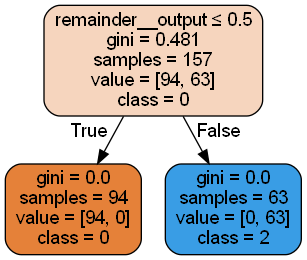

In [94]:
from sklearn.tree import export_graphviz
from IPython.display import display, Image
import graphviz

# Perform cross-validated predictions
y_pred_cv = model_2_pred

# Get the indices of correctly classified instances
correct_indices = (y == y_pred_cv)

# Use the correct indices to fit the model on the entire dataset
model_2_pipeline.fit(X[correct_indices], y[correct_indices])

# Get the transformed feature names from the preprocessor
transformed_feature_names = list(ct_no_standardize.get_feature_names_out(X.columns))

# Convert class names to strings
class_names_str = model_2_pipeline.named_steps['des_classification'].classes_.astype(str)

# Export the decision tree to a DOT file
dot_data = export_graphviz(model_2_pipeline.named_steps['des_classification'],
                           feature_names=transformed_feature_names,
                           class_names=class_names_str,  # Convert class names to strings
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           out_file=None)

# Render the decision tree directly
graph = graphviz.Source(dot_data, format="png")
display(Image(graph.render(format='png', cleanup=True)))

### Interpreting Decision Tree

- When tuning the decision tree, the best max_depth to utilize is 1, therefore there is only one node at the top that is the best at splitting the data. This best predictor variable is output which is makes sense as this is whether a person is at risk vs not of a heart attack. We can interpret the tree to say that if someone is at risk of heart attack then they are more likely to be class 0 for chest pain and if they are not at risk then they are more likely to be class 2 for chest pain.

### LDA

In [95]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Model Specification
lda = LinearDiscriminantAnalysis()

#pipeline Creation
model_3_pipeline = Pipeline(
    [
    ("lda_classification", lda)]
  )

model_3 = model_3_pipeline.fit(X,y)

model_3_pred = model_3.predict(X)

# Metrics for Model 3
print("Metrics for Model_3 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_3_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_3_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_3 :

Mean Accuracy Score: 0.5711640211640211 

Confusion Matrix for Model_3 : 



,3,2,1,0
3,98,2,27,1
2,8,2,32,2
1,21,5,55,0
0,7,0,11,2


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [96]:
#creating the variables to do one versus rest from cp categories
ha['cp_is_3'] = ha['cp'] == 3
ha['cp_is_2'] = ha['cp'] == 2
ha['cp_is_1'] = ha['cp'] == 1
ha['cp_is_0'] = ha['cp'] == 0
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,True,False,False,False
1,37,1,2,130,250,1,187,1,False,True,False,False
2,56,1,1,120,236,1,178,1,False,False,True,False
3,57,0,0,120,354,1,163,1,False,False,False,True
4,57,1,0,140,192,1,148,1,False,False,False,True


### OvR cp_is_3 vs rest

In [97]:
X= ha.drop(['cp', "cp_is_3", "cp_is_2","cp_is_1","cp_is_0"], axis=1)
y = ha["cp_is_3"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
0,0.0001,0.1,0.0


- note an f1 score of 0 is not impossible but it perhaps says something about our procedure. We go forward to see how the rest perform

### OvR cp_is_2 vs rest

In [98]:
X= ha.drop(['cp', "cp_is_3", "cp_is_2","cp_is_1","cp_is_0"], axis=1)
y = ha["cp_is_2"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
35,10,0.9,0.136768


- Note an f1 score for cp of 2 vs rest means that the model is perhaps not the best at finding the cp 2.

### OvR cp_is_1 vs rest

In [99]:
X= ha.drop(['cp', "cp_is_3", "cp_is_2","cp_is_1","cp_is_0"], axis=1)
y = ha["cp_is_1"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
0,0.0001,0.1,0.0


- Note another f1 score of 0 says this is perhhaps not the best way to approach finding the cp of 1

### OvR cp_is_0 vs rest

In [100]:
X= ha.drop(['cp', "cp_is_3", "cp_is_2","cp_is_1","cp_is_0"], axis=1)
y = ha["cp_is_0"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
22,0.1,0.8,0.727824


- this is the only model that is remotely acceptable in terms of performance as measured by f1 score with a score of .72, to predict chest pain category 0 with respect to the rest of the types of chest pain, this is perhaps due to the data itself where there are more observations with cp 0 relative to the other categories.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

### OvO cp 0 vs 1

In [101]:
ha_0_1 = ha[(ha['cp'] == 0) | (ha['cp'] == 1)]
ha_0_1 = ha_0_1.drop(["cp_is_3","cp_is_2","cp_is_1","cp_is_0"], axis = 1)

X = ha_0_1.drop(['cp'], axis = 1)
y = ha_0_1["cp"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='roc_auc_ovo')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "roc_auc_ovo": mean_test_scores}).sort_values(by='roc_auc_ovo', ascending=False)
model_scores[0:1]

,lambdas,alphas,roc_auc_ovo
21,0.1,0.6,0.835962


A Roc_auc_ovo score of 84% is quite admirable between chest pain category 0 and 1.

### OvO cp 0 vs 2

In [102]:
ha_0_2 = ha[(ha['cp'] == 0) | (ha['cp'] == 2)]
ha_0_2 = ha_0_2.drop(["cp_is_3","cp_is_2","cp_is_1","cp_is_0"], axis = 1)

X = ha_0_2.drop(['cp'], axis = 1)
y = ha_0_2["cp"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='roc_auc_ovo')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "roc_auc_ovo": mean_test_scores}).sort_values(by='roc_auc_ovo', ascending=False)
model_scores[0:1]

,lambdas,alphas,roc_auc_ovo
23,0.1,0.9,0.782519


- a roc_auc_ovo score of 78% is still good for predicting between cp categoreies 0 and 2.

### OvO cp 0 vs 3

In [103]:
ha_0_3 = ha[(ha['cp'] == 0) | (ha['cp'] == 3)]
ha_0_3 = ha_0_3.drop(["cp_is_3","cp_is_2","cp_is_1","cp_is_0"], axis = 1)

X = ha_0_3.drop(['cp'], axis = 1)
y = ha_0_3["cp"]

#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='roc_auc_ovo')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "roc_auc_ovo": mean_test_scores}).sort_values(by='roc_auc_ovo', ascending=False)

model_scores[0:1]

,lambdas,alphas,roc_auc_ovo
19,0.1,0.2,0.760897


- a roc_auc_ovo score of 76% is still good for categories cp 0 vs 3.

### Which pair was the OvO approach best at distinguishing?

The best pair to distinguish from in terms of our logistic regression models was chest pain category 0 and 1. The roc auc ovo score for the model was 84% which was greatly increased compared to the others of 78% and 76% for chest pain categories 0 vs 2 and 0 vs 3 respectively.